Import packages

In [1]:
#
import os
import sys
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


Read data from 'datasets/PRSA_data_2010.1.1-2014.12.31.csv' and return a dateframe df

In [2]:
df = pd.read_csv('datasets/PRSA_data_2010.1.1-2014.12.31.csv')

In [3]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


Add a column of 'datatime' from year, month, day, and hour. 

In [4]:
df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(
    lambda row: datetime.datetime(year=row['year'], month=row['month'], day=row['day'],
                                 hour=row['hour']), axis=1)

In [5]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


Sort df by 'datetime'

In [6]:
df.sort_values('datetime', ascending=True, inplace=True)

Check outlier of df['PRES'] by box plot. You should find no outlier.

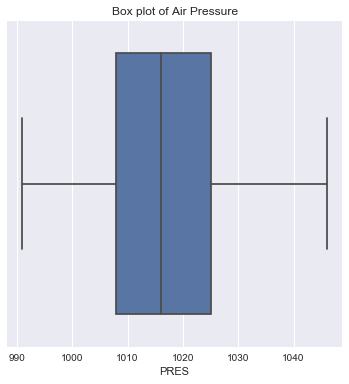

In [7]:
plt.figure(figsize=(6,6))
g = sns.boxplot(df['PRES'])
g.set_title('Box plot of Air Pressure')

Plot df['PRES']

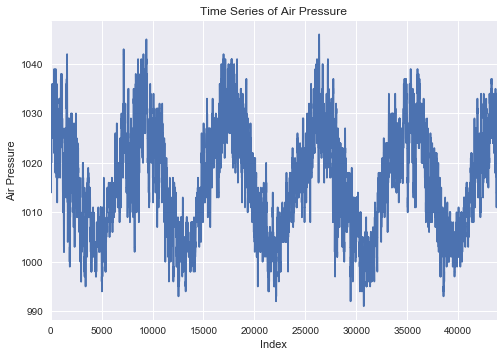

In [8]:
g = sns.tsplot(df['PRES'])
g.set_title('Time Series of Air Pressure')
g.set_xlabel('Index')
g.set_ylabel('Air Pressure')

Normalize df['PRES'] to [0, 1]

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [11]:
df['scaled_PRES'] = scaler.fit_transform(np.array(df['PRES']).reshape([-1, 1]))

In [12]:
df.head(10)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,0.545455
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,0.527273
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,0.509091
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,0.509091
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,0.490909
5,6,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0,2010-01-01 05:00:00,0.472727
6,7,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0,2010-01-01 06:00:00,0.472727
7,8,2010,1,1,7,NaN,-19,-9.0,1017.0,NW,21.02,0,0,2010-01-01 07:00:00,0.472727
8,9,2010,1,1,8,NaN,-19,-9.0,1017.0,NW,24.15,0,0,2010-01-01 08:00:00,0.472727
9,10,2010,1,1,9,NaN,-20,-8.0,1017.0,NW,27.28,0,0,2010-01-01 09:00:00,0.472727


Split df to df_train and df_val. Here df_train is before 2014-01-01 00:00:00, and df_val is after that.

In [13]:
split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)
df_train = df.loc[df['datetime']<split_date]
df_val = df.loc[df['datetime']>=split_date]
print('Shape of train', df_train.shape)
print('Shape of validation', df_val.shape)

Shape of train (35064, 15)
Shape of validation (8760, 15)


Generate training and validation date for the prediction model of $X_t = f(X_{(t-1)}, ..., X_{(t-7)})$

In [14]:
def makeXy(ts, nb_timesteps):
    X = []
    y = []
    
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.iloc[i-nb_timesteps:i]))
        y.append(ts.iloc[i])
        
    X, y = np.array(X), np.array(y)
    
    return X, y

In [15]:
X_train, y_train = makeXy(df_train['scaled_PRES'], 7)
print(X_train.shape, y_train.shape)

(35057, 7) (35057,)


In [16]:
X_val, y_val = makeXy(df_val['scaled_PRES'], 7)
print(X_val.shape, y_val.shape)

(8753, 7) (8753,)


Define a MLP with this structure: Input -> dense1(32) -> dense2(16) -> dense3(16) -> dropout(0.2) -> Output 

In [17]:
input_layer = Input(shape=(7,), dtype='float32')

In [18]:
dense1 = Dense(32, activation='relu')(input_layer)
dense2 = Dense(16, activation='relu')(dense1)
dense3 = Dense(16, activation='relu')(dense2)

In [19]:
# dense1 = Dense(32, activation='linear')(input_layer)
# dense2 = Dense(16, activation='linear')(dense1)
# dense3 = Dense(16, activation='linear')(dense2)

In [20]:
dropout_layer = Dropout(0.2)(dense3)

In [21]:
output_layer = Dense(1, activation='linear')(dropout_layer)

Train the model to 
1. Minimize MSE.
2. Train 20 epoches
3. Define a checkpoint to save the best model
4. 

In [22]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_squared_error', optimizer='adam')
ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
_________________________________________________________________


In [23]:
save_weight_at = os.path.join('keras_models', 'AirPressure_MLP.hdf5')

In [24]:
save_best = ModelCheckpoint(save_weight_at, monitor='val_loss', verbose=0,
                           save_best_only=True, save_weights_only=False, mode='min',
                           period=1)

In [25]:
ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
            verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
            shuffle=True)

Train on 35057 samples, validate on 8753 samples
Epoch 1/20
35057/35057 [==============================] - 3s 75us/step - loss: 0.0064 - val_loss: 2.3341e-04
Epoch 2/20
35057/35057 [==============================] - 3s 72us/step - loss: 0.0015 - val_loss: 4.4770e-04
Epoch 3/20
35057/35057 [==============================] - 2s 68us/step - loss: 0.0015 - val_loss: 1.4860e-04
Epoch 4/20
35057/35057 [==============================] - 2s 66us/step - loss: 0.0015 - val_loss: 1.6923e-04
Epoch 5/20
35057/35057 [==============================] - 2s 66us/step - loss: 0.0015 - val_loss: 2.7659e-04
Epoch 6/20
35057/35057 [==============================] - 2s 64us/step - loss: 0.0015 - val_loss: 2.3652e-04
Epoch 7/20
35057/35057 [==============================] - 2s 63us/step - loss: 0.0015 - val_loss: 1.6895e-04
Epoch 8/20
35057/35057 [==============================] - 2s 63us/step - loss: 0.0015 - val_loss: 1.4532e-04
Epoch 9/20
35057/35057 [==============================] - 2s 64us/step - loss: 

Load the best model to predict validation data. Assess the quality of prediction by r2_score

In [26]:
best_model = load_model(os.path.join('keras_models', 'AirPressure_MLP.hdf5'))

In [27]:
preds = best_model.predict(X_val)

In [28]:
pred_PRES = scaler.inverse_transform(preds)

In [29]:
from sklearn.metrics import r2_score

In [30]:
r2 = r2_score(df_val['PRES'].iloc[7:], pred_PRES)
print(r2)

0.995422595862


Plot and compare the prediction and the true data.

In [31]:
pred_PRES = pred_PRES.ravel()

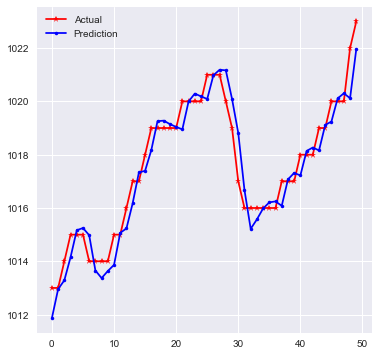

In [32]:
plt.figure(figsize=(6, 6))
plt.plot(range(50), df_val['PRES'].iloc[7:57], linestyle='-', marker='*', color='r', label='Actual')
plt.plot(range(50), pred_PRES[:50], linestyle='-', marker='.', color='b', label='Prediction')
plt.legend()